In [1]:
from google.colab import drive
import os
import sys
if 'google.colab' in str(get_ipython()):
  if 'drive' not in os.listdir():
      drive.mount('/content/drive')

# Скрипт по подготовке данных для моделирования

## Импорт модулей и подгрузка конфига

In [2]:
# !pip install -q pytorch-lifestream==0.5.2

In [3]:
import os
import sys
import yaml
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import ptls
from ptls.preprocessing import PandasDataPreprocessor

In [4]:
os.listdir('drive/My Drive/pytorch-lifestream/configs')

['sberhack_gender_prediction_data.yaml',
 'rosbank_churn_prediction_data.yaml',
 'sber_age_prediction_data.yaml',
 'datafusion_churn_prediction_data.yaml',
 'alpha_bki_scoring_prediction_data.yaml']

In [5]:
config_name = 'datafusion_churn_prediction_data.yaml'
path_to_working_directory = 'drive/My Drive/pytorch-lifestream'

with open(os.path.join(path_to_working_directory,'configs',config_name),'r') as f:
  config = yaml.safe_load(f)

## Загрузка данных и разбиение на train/valid

In [ ]:
# загрузка событий
if '.csv' in config['events_file']:
    events = pd.read_csv(os.path.join(config['path_folder'],config['events_file']), index_col=config['id_col'])
else:
    events = pd.read_parquet(os.path.join(config['path_folder'],config['events_file']))
    events.set_index(config['id_col'],inplace=True)

if config.get('events_test',False):
    test_evetns = pd.read_parquet(os.path.join(config['path_folder'],config['events_test']))
    test_evetns.set_index(config['id_col'],inplace=True)
    events = pd.concat([events,test_evetns])

if config['need_time_preprocess']:
  if config_name == 'sberhack_gender_prediction_data.yaml':
      events[config['time_col']] = pd.to_datetime(events[config['time_col']]\
                                      .map(lambda x: f"{2022 + int(x.split()[0]) // 365} {int(x.split()[0]) % 365 + 1} {x.split()[1]}"),
                                      format = '%Y %j %H:%M:%S')

      events['month'] = events[config['time_col']].dt.month
      events['day_of_month'] = events[config['time_col']].dt.day
      events['hour'] = events[config['time_col']].dt.hour

  elif config_name == 'rosbank_churn_prediction_data.yaml':
      events[config['time_col']] = pd.to_datetime(events[config['time_col']])
      events['month'] = events[config['time_col']].dt.month
      events['day_of_month'] = events[config['time_col']].dt.day


  elif config_name == 'datafusion_churn_prediction_data.yaml':
      events[config['time_col']] = pd.to_datetime(events[config['time_col']])

  assert pd.api.types.is_datetime64_any_dtype(events[config['time_col']]), 'Не выполнена обработка временного поля'


In [8]:
# загрузка меток
train = pd.read_csv(os.path.join(config['path_folder'],config['train_file']),index_col=config['id_col'])[[config['target_col']]]
if config.get('test_file',False):
    test = pd.read_csv(os.path.join(config['path_folder'],config['test_file']),index_col=config['id_col'])
if config.get('add_file',False):
    add_file = pd.read_csv(os.path.join(config['path_folder'],config['add_file']),index_col=config['id_col'])
    train = train.merge(add_file,how='left',left_index=True,right_index=True)

# train valid test split
if config.get('test_file',False) == False:
    train, test = train_test_split(train,
                                   test_size=config['test_size'] + config['val_size'],
                                   random_state=config['random_state'],
                                   stratify=train[config['target_col']])

    valid, test = train_test_split(test,
                                   test_size=config['test_size']/(config['test_size'] + config['val_size']),
                                   random_state=config['random_state'],
                                   stratify=test[config['target_col']])
else:
    train, valid = train_test_split(train,
                                    test_size=config['val_size'],
                                    random_state=config['random_state'],
                                    stratify=train[config['target_col']])

events_train = events.merge(train, how='inner',left_index=True,right_index=True).reset_index()
events_valid = events.merge(valid, how='inner',left_index=True,right_index=True).reset_index()
events_test = events.merge(test, how='inner',left_index=True,right_index=True).reset_index()

## Препроцессинг

In [11]:
use_cols = [config['id_col'], config['time_col'], config['target_col']] + config['numeric_cols'] + config['category_cols']
preprocessor = PandasDataPreprocessor(
    col_id=config['id_col'],
    col_event_time=config['time_col'],
    event_time_transformation='dt_to_timestamp' if config['need_time_preprocess'] else 'none',
    cols_category=config['category_cols'],
    cols_numerical=config['numeric_cols'],
    return_records=True,
    cols_first_item=config['target_col'],
)

df_data_train = preprocessor.fit_transform(events_train[use_cols])
df_data_valid = preprocessor.transform(events_valid[use_cols])
use_cols.remove(config['target_col'])
df_data_test = preprocessor.transform(events_test[use_cols])

In [12]:
pd.DataFrame(df_data_train).sample(5)

,user_id,target,event_time,mcc_code,currency_rk,employee_count_nm,bankemplstatus,customer_age,report,transaction_amt
1173,12827,0,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(9), tensor(9), tensor(92), tensor(92),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(7), tensor(7), tensor(7), tensor(7), t...","[tensor(-2416.5740, dtype=torch.float64), tens..."
43142,465077,1,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(3), tensor(8), tensor(6), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(8181.7378, dtype=torch.float64), tenso..."
9933,106268,1,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(4), tensor(4), tensor(4), tensor(4), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(8), tensor(8), tensor(8), tensor(8), t...","[tensor(-15495.7979, dtype=torch.float64), ten..."
48622,523970,1,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(49), tensor(49), tensor(4), tensor(10)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(-37.6023, dtype=torch.float64), tensor..."
32455,352884,0,"[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(4), tensor(5), tensor(5), tensor(4), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(-3734.2974, dtype=torch.float64), tens..."


## Сохранение данных

In [13]:
joblib.dump(df_data_train,os.path.join(config['path_folder'],'train_'+config_name.replace('yaml','pickle')))
joblib.dump(df_data_valid,os.path.join(config['path_folder'],'valid_'+config_name.replace('yaml','pickle')))
joblib.dump(df_data_test,os.path.join(config['path_folder'],'test_'+config_name.replace('yaml','pickle')))
joblib.dump(preprocessor,os.path.join(config['path_folder'],'preprocessor_'+config_name.replace('yaml','pickle')))
print('Завершена предобработка данных')

Завершена предобработка данных


In [ ]:
 preprocessor.get_category_dictionary_sizes()

# EDA датасета

,target,count,mean,std,min,25%,50%,75%,max
0,0,55654.0,137.959895,149.773487,11.0,35.0,84.0,189.75,1497.0
1,1,5146.0,118.994170,132.454457,11.0,32.0,71.0,158.00,1488.0


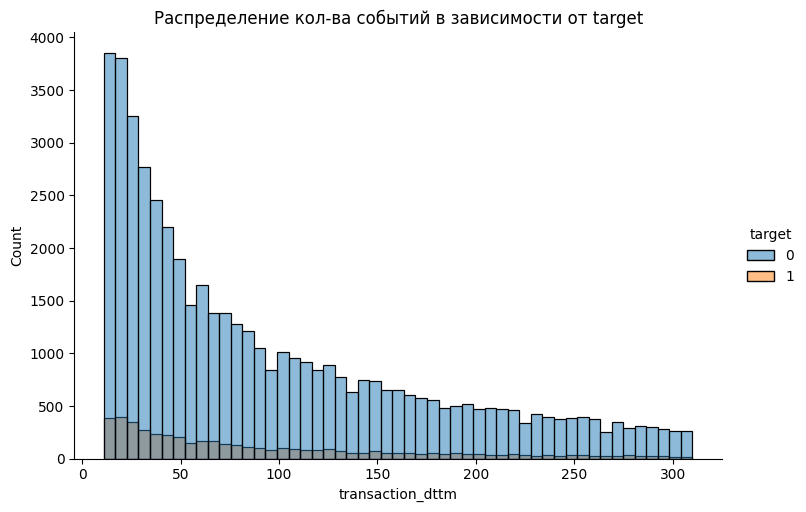

In [14]:
eda_data = pd.concat([events_train[[config['id_col'], config['time_col'], config['target_col']]],
     events_valid[[config['id_col'], config['time_col'], config['target_col']]]]).reset_index()
cnt_events = eda_data.groupby([config['id_col'],config['target_col']],as_index=False)[config['time_col']].count()

cnt_events_stats = cnt_events.groupby([config['target_col']],as_index=False)[config['time_col']].describe()
cnt_events_stats.to_csv(os.path.join(config['path_folder'],'count_events_stat.csv'),index=False,header=True)
display(cnt_events_stats)

iqr = cnt_events[config['time_col']].quantile(0.75) - cnt_events[config['time_col']].quantile(0.25)
iqr_mask = cnt_events[config['time_col']] <= cnt_events[config['time_col']].quantile(0.5) + 1.5 * iqr
sns.displot(cnt_events[iqr_mask],
                       x=config['time_col'],hue=config['target_col'],aspect=1.5)
plt.title(f"Распределение кол-ва событий в зависимости от {config['target_col']}")
plt.savefig(os.path.join(config['path_folder'],'count_events_distribution.png'))
plt.show()